# Downloading the data and data preparation functions initialization

In [1]:
# install a specific version of the albumentations library 
!pip install albumentations==0.4.6

# imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch.utils.data as utils
import pandas as pd
import itertools
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import warnings
warnings.filterwarnings('ignore')
from torch.utils.tensorboard import SummaryWriter


# choose a device (GPU or CPU) to perfrom training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is being used.")


# download the data and unzip it
!wget -c https://www.dropbox.com/s/yriw82at8fbepsy/fer2013.tar.gz
!tar -xvf /content/fer2013.tar.gz


### DATA PREPARATION FUNCTIONS ###
def get_data(dataset_path="/content/fer2013/fer2013.csv", display_random=True):
    """
    Function takes a path to a dataset and returns training, validation and test sets and labels as python lists.

    Input: 1) dataset_path - a path to the dataset
           2) display_random - flag to indicate whether to display a random image for the dataset (Bool)

    Return: 1) train_X - train set of images
            2) train_y - train set of labels
            3) val_X - validation set of images
            4) val_y - validation set of labels
            5) test_X - test set of images
            6) test_y - test set of labels
    """
    # read the data set as a pandas dataframe
    df = pd.read_csv(dataset_path)

    # display the length of the data subsets
    print(f"The length of the training set: {len(df[df['Usage']=='Training'])} samples")
    print(f"The length of the public test set: {len(df[df['Usage']=='PublicTest'])} samples")
    print(f"The length of the private training set: {len(df[df['Usage']=='PrivateTest'])} samples")

    # create a new column with pixels converted to numpy arrays of the size (48, 48)
    width, height = 48, 48
    df['faces'] = [np.asarray([int(pixel) for pixel in x.split()]).reshape(width, height).astype('float32') for x in df['pixels']]

    # displays a random image with its label
    if display_random:
        display_random_pic(list(df['faces']), list(df['emotion']))

    # divide the dataframe into training, validation and test dataframe subsets
    df_train = df[df['Usage'] == 'Training']
    df_valid = df[df['Usage'] == 'PrivateTest']
    df_test = df[df['Usage'] == 'PublicTest']

    # form training, validation and test sets 
    # images
    train_X = df_train['faces'].tolist()
    val_X = df_valid['faces'].tolist()
    test_X = df_test['faces'].tolist()
    # labels
    train_y = df_train['emotion'].tolist()
    val_y = df_valid['emotion'].tolist()
    test_y = df_test['emotion'].tolist()

    return train_X, train_y, val_X, val_y, test_X, test_y


def display_random_pic(faces, emotions):
    """
    Displays a random image with its label.

    Input: 1) faces - list of images
           2) emotions - list of labels

    Return: display a random image from the input
    """
    # classes definition
    classes = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    idx = np.random.randint(len(faces))
    print(classes[emotions[idx]])
    plt.imshow(faces[idx], cmap='gray')
    plt.axis('off')
    plt.show()


class CustomDataset(utils.Dataset):
    """
    Defines a PyTorch dataset class that parses a raw data to create a Dataset with (image, label) pairs.
    Stores the samples and their corresponding labels.
    """
    def __init__(self, X, y, transforms=None):
        "Initialization"
        self.transforms = transforms
        self.X = np.asarray(X, dtype=np.float32).astype(np.float32)
        self.y = y

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)
    
    def __getitem__(self, index):
        "get data and get label"
        image = self.X[index]
        label = self.y[index]

        # duplicate gray scale channel to make 3-channel tensor
        image = np.stack([image] * 3, axis=-1)
        # scale the image
        # image /= 255.
        # apply the transformations
        if self.transforms:
            image = self.transforms(image=image)['image']
            
        return image, torch.tensor(label, dtype=torch.long)
        

def get_train_transforms():
    """
    Function that creates transformations for a training set

    Return: transformations for a training set
    """
    return A.Compose(
        [    
            A.HorizontalFlip(p=0.5), # Flip the input horizontally around the y-axis.
            A.VerticalFlip(p=0.3), # Flip the input vertically around the x-axis.
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.2), # Rotate the input by an angle selected randomly from the uniform distribution.
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.2), # CoarseDropout of the square regions in the image.
            A.GaussNoise(p=0.2), # Apply gaussian noise to the input image.
            ToTensorV2(p=1.0), # Convert to Tensor
        ], 
        p=1.0)


def get_valid_transforms():
    """
    Function that creates transformations for validation and test sets

    Return: transformations for val and test sets
    """
    return A.Compose(
        [
            ToTensorV2(p=1.0), # Convert to Tensor
        ], 
        p=1.0
    )


def get_dataloaders(train_X, train_y, val_X, val_y, test_X, test_y, bs=64):
    """
    Function takes training, validation and test datasets and return Pytorch dataloaders
    that wraps an iterable around the Dataset to enable easy access to the samples.

    Input:1) train_X - train set of images
          2) train_y - train set of labels
          3) val_X - validation set of images
          4) val_y - validation set of labels
          5) test_X - test set of images
          6) test_y - test set of labels
          7) bs - the size of batch size
    
    Return:1) trainloader - training loader
           2) valloader - validation loader
           3) testloader - test loader
    """
    # specify dataloaders parameters
    batch_size = bs
    num_workers = 2
    # create Pytorch train, val and test datasets
    train_dataset = CustomDataset(train_X, train_y, transforms=get_train_transforms())
    val_dataset = CustomDataset(val_X, val_y, transforms=get_valid_transforms())
    test_dataset = CustomDataset(test_X, test_y, transforms=get_valid_transforms())

    # create Pytorch dataloaders that wraps an iterable around the Dataset to enable easy access to the samples
    trainloader = utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valloader = utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    testloader = utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return trainloader, valloader, testloader


### MODEL TRAINING FUNCTIONS ###
def train_model(model, criterion, optimizer, trainloader, validloader, epochs=50, save=True, scheduler=None, scheduler_mode='epoch'):
    """
    Function takes a model and training parameters and performs training.

    Input: 1) model - the model to train
           2) criterion - loss function
           3) optimizer - optimization algorithm
           4) trainloader - training loader
           5) validloader - validation loader
           6) epochs - the number of epochs to train the model
           7) save - a flag to indicate to save the model if it decreases validation loss (Bool)
           8) scheduler - function to control the learning rage of the training
           9) scheduler_mode - method to apply scheduler: "epoch" applies every epoch iteration, "batch" applies every batch iteration (str)

    Return: 1) model - the trained model
            2) train_losses - list of training epoch loss
            3) val_losses - list of validation epoch loss
    """
    train_losses = []
    val_losses = []
    # initial threshold for model saving
    val_loss_min = np.Inf

    # iterate over epochs
    for epoch in range(epochs):
        ### TRAINING ###
        train_running_loss = 0
        train_accuracy = 0

        # set a model to the training mode
        model.train()

        # iterate over batches
        for images, labels in trainloader:
            # put images and labels of a batch on GPUs
            images, labels = images.cuda(), labels.long().cuda()
            # clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()
            # perform modeling for each image batch, return log softmax of the logits (log of probabilities)
            log_probs = model(images)[-1]
            # calculate the loss
            loss = criterion(log_probs, labels)
            # calculate gradients of parameter (model learns by backpropagating)
            loss.backward()
            # optimize the model weights
            optimizer.step()

            # scheduler to adjust the learning rate
            if scheduler is not None:
                if scheduler_mode == 'batch':
                    # print("scheduler works with batches")
                    scheduler.step()

            # calculate the training loss
            train_running_loss += loss.item()            
            # output of the model are log-probabilities, need to take exponential to get the probability distribution over the classes
            probs = torch.exp(log_probs)

            # higher the probability for a class, the more the network thinks that the image is of the particular class, get the index of the highest probability
            _, predicted = torch.max(probs.data, 1)
            matched = (predicted == labels).squeeze()
            # calculate the training accuracy
            train_accuracy += torch.mean(matched.type(torch.FloatTensor))

        # calculate the epoch training loss
        train_losses.append(train_running_loss / len(trainloader))

        ### TESTING ###
        val_running_loss = 0
        val_accuracy = 0
        # initialize lists for the confusion matrix
        y_pred_list = []
        y_gt_list = []

        # set a model to the evaluation mode (freeze the weights)
        model.eval()

        # disable the backpropogation
        with torch.no_grad():
            # iterate over batches
            for images, labels in validloader:
                # put images and labels of a batch on GPUs
                images, labels = images.cuda(), labels.long().cuda()
                # perform modeling for each image batch,
                log_probs = model(images)[-1]
                # calculate the validation loss
                val_running_loss += criterion(log_probs, labels)
                # get the probability distribution over the classes
                probs = torch.exp(log_probs)
                # get the index of the highest probability
                _, predicted = torch.max(probs.data, 1)
                matched = (predicted == labels).squeeze()
                # calculate the accuracy
                val_accuracy += torch.mean(matched.type(torch.FloatTensor))

                # append the lists with predictions and labels to calculate F1 score, precision and recall
                y_pred_list.append(predicted.cpu().numpy())
                y_gt_list.append(labels.cpu().numpy())
        
        # calculate and report accuracy, F1 score, precision, and recall of the validation set
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
        y_gt_list = [a.squeeze().tolist() for a in y_gt_list]
        y_pred_list_new = list(itertools.chain.from_iterable(y_pred_list))
        y_gt_list_new = list(itertools.chain.from_iterable(y_gt_list))

        # calculate the epoch validation loss
        val_losses.append(val_running_loss / len(validloader))

        # report the performance of the current epoch
        print(f"Epoch {epoch+1} ===> {epochs}: ",
              f"Training loss: {train_losses[-1]:.3f} |",
              f"Validation loss: {val_losses[-1]:.3f} |",
              f"Training accuracy: {train_accuracy/len(trainloader):.3f} |",
              f"Validation accuracy: {val_accuracy/len(validloader):.3f} |")
        
        print("Validation metrics:")
        print("\n")
        print(classification_report(np.asarray(y_gt_list_new, dtype=np.float32), np.asarray(y_pred_list_new, dtype=np.float32)))
        print("\n")

        if save:
            # save the model if it decreases validation loss
            if val_running_loss / len(validloader) <= val_loss_min:
                print(f"The validation loss has decreased: {val_loss_min:.4f} ===> {val_running_loss/len(validloader):.4f}")
                print("Start saving the model...")
                torch.save(model.state_dict(), 'opt_model.pt')
                val_loss_min = val_running_loss/len(validloader)
                print("The model has been successfully saved.")

        if scheduler is not None:
            if scheduler_mode == 'epoch':
                # print("scheduler works with epochs")
                scheduler.step()

    return model, train_losses, val_losses

     |████████████████████████████████| 122kB 8.1MB/s 
     |████████████████████████████████| 952kB 33.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=1a0e0a7a335ad5adcacd0d7af0ee552796cf7459f39ab93627cde5fa8e990cfd
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
cuda is being used.
--2021-05-25 11:29:09--  https://www.dropbox.com/s/yriw82at8fbepsy/fer2013.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 M

# Models

In [2]:
### MODELS ###

# Model 1 (Version of filters 1)
class Net1_1(nn.Module):
    def __init__(self, kernel_size = 5, dropout=0.0):
        super(Net1_1, self).__init__()
        self.dropout = dropout

        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # fc layers
        if kernel_size == 5:
            self.fc1 = nn.Sequential(
                nn.Linear(4608, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(self.dropout)) 

        elif kernel_size == 3:
            self.fc1 = nn.Sequential(
                nn.Linear(8192, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True))

        self.fc2 = nn.Linear(64, 7) 
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x, self.log_softmax(x)


# Model 1 (Version of filters 2)
class Net1_2(nn.Module):
    def __init__(self, kernel_size = 5, dropout=0.0):
        super(Net1_2, self).__init__()
        self.dropout = dropout

        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        
        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # fc layers
        if kernel_size == 5:
            self.fc1 = nn.Sequential(
                nn.Linear(9216, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(self.dropout)) 

        elif kernel_size == 3:
            self.fc1 = nn.Sequential(
                nn.Linear(16384, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True))

        self.fc2 = nn.Linear(64, 7) 
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x, self.log_softmax(x)


# Model 1 (Version of filters 3)
class Net1_3(nn.Module):
    def __init__(self, kernel_size = 5, dropout=0.0):
        super(Net1_3, self).__init__()
        self.dropout = dropout

        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))

        # fc layers
        if kernel_size == 5:
            self.fc1 = nn.Sequential(
                nn.Linear(18432, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(self.dropout)) 

        elif kernel_size == 3:
            self.fc1 = nn.Sequential(
                nn.Linear(32768, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True))

        self.fc2 = nn.Linear(64, 7) 
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x, self.log_softmax(x)



# Model 2
class Net2(nn.Module):
    def __init__(self, dropout=0.0):
        super(Net2, self).__init__()

        self.dropout = dropout

        self.conv_module = nn.Sequential(OrderedDict([
            # layer 1
            ("conv1", nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)),
            ("batch1", nn.BatchNorm2d(8)),
            ("relu1", nn.ReLU(inplace=True)),
            ("dropout1", nn.Dropout(self.dropout)),   
            ("maxpool1", nn.MaxPool2d(2, 1)),

            # layer 2
            ("conv2", nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)),
            ("batch2", nn.BatchNorm2d(16)),
            ("relu2", nn.ReLU(inplace=True)),
            ("dropout2", nn.Dropout(self.dropout)),              
            ("maxpool2", nn.MaxPool2d(2, 1)),

            # layer 3
            ("conv3", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)),
            ("batch3", nn.BatchNorm2d(32)),
            ("relu3", nn.ReLU(inplace=True)),
            ("dropout3", nn.Dropout(self.dropout)),              
            ("maxpool3", nn.MaxPool2d(2, 1)),

            # layer 4
            ("conv4", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
            ("batch4", nn.BatchNorm2d(64)),
            ("relu4", nn.ReLU(inplace=True)),
            ("dropout4", nn.Dropout(self.dropout)),              
            ("maxpool4", nn.MaxPool2d(2, 1)),

            # layer 5
            ("conv5", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
            ("batch5", nn.BatchNorm2d(128)),
            ("relu5", nn.ReLU(inplace=True)),
            ("dropout5", nn.Dropout(self.dropout)),              
            ("maxpool5", nn.MaxPool2d(2, 2)),          

            # layer 6           
            ("conv6", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)),
            ("batch6", nn.BatchNorm2d(256)),
            ("relu6", nn.ReLU(inplace=True)),
            ("dropout6", nn.Dropout(self.dropout)),              
            ("maxpool6", nn.MaxPool2d(2, 2)),   

            # layer 7
            ("conv7", nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)),
            ("batch7", nn.BatchNorm2d(256)),
            ("relu7", nn.ReLU(inplace=True)),
            ("dropout7", nn.Dropout(self.dropout)),              
            ("maxpool7", nn.MaxPool2d(2, 2))

            ]))
        
        self.fc_module = nn.Sequential(OrderedDict([
            # layer 1
            ("fc1", nn.Linear(1024, 512)),
            ("bn1",  nn.BatchNorm1d(512)),
            ("relu1", nn.ReLU(inplace=True)),
            ("dropout1", nn.Dropout(self.dropout)),   

            # layer 2           
            ("fc2", nn.Linear(512, 256)),
            ("bn2",  nn.BatchNorm1d(256)),
            ("relu2", nn.ReLU(inplace=True)),
            ("dropout2", nn.Dropout(self.dropout)),   

            # layer 3 
            ("fc3", nn.Linear(256, 7)),
                                          
            ]))

        self.log_softmax = nn.LogSoftmax(dim=1)
      
    def forward(self, x):
        x = self.conv_module(x)
        x = x.view(x.size(0), -1)
        x = self.fc_module(x)

        return x, self.log_softmax(x)

# Model 3
class UpgradedNet(nn.Module):
    def __init__(self, dropout=0.0, channel_coef=1):
        super(UpgradedNet, self).__init__()
        self.dropout = dropout
        self.channel_coef = channel_coef

        # convolutional part of the architecture
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32*self.channel_coef, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn2 = nn.Conv2d(in_channels=32*self.channel_coef, out_channels=64*self.channel_coef, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn3 = nn.Conv2d(in_channels=64*self.channel_coef, out_channels=128*self.channel_coef, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn4 = nn.Conv2d(in_channels=128*self.channel_coef, out_channels=256*self.channel_coef, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn5 = nn.Conv2d(in_channels=256*self.channel_coef, out_channels=512*self.channel_coef, kernel_size=(1, 1), padding=1 , bias=False)
        self.cnn6 = nn.Conv2d(in_channels=512*self.channel_coef, out_channels=1024*self.channel_coef, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn7 = nn.Conv2d(in_channels=1024*self.channel_coef, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn8 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False)
        self.cnn9 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False)
        self.cnn10 = nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)

        # batch normalizaition part
        self.bn1 = nn.BatchNorm2d(32*self.channel_coef)
        self.bn2 = nn.BatchNorm2d(64*self.channel_coef)
        self.bn3 = nn.BatchNorm2d(128*self.channel_coef)
        self.bn4 = nn.BatchNorm2d(256*self.channel_coef)
        self.bn5 = nn.BatchNorm2d(512*self.channel_coef)
        self.bn6 = nn.BatchNorm2d(1024*self.channel_coef)
        self.bn7 = nn.BatchNorm2d(1024)
        self.bn8 = nn.BatchNorm2d(512)
        self.bn9 = nn.BatchNorm2d(256)

        # activation
        self.relu = nn.ReLU()

        # max pooling
        self.max_pool = nn.MaxPool2d(2, 2)

        # avg pooling
        self.avg_pool = nn.AvgPool2d(kernel_size=4)

        # dropout
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x):
        # layer 1
        conv1 = self.cnn1(x)
        activ1 = self.relu(conv1)
        cnn_bn1 = self.bn1(activ1)

        # layer 2
        conv2 = self.cnn2(cnn_bn1)
        activ2 = self.relu(conv2)
        cnn_bn2 = self.bn2(activ2)

        # max pooling 1
        m_pool1 = self.max_pool(cnn_bn2)

        # layer 3
        conv3 = self.cnn3(m_pool1)
        activ3 = self.relu(conv3)
        cnn_bn3 = self.bn3(activ3)

        # layer 4
        conv4 = self.cnn4(cnn_bn3)
        activ4 = self.relu(conv4)
        cnn_bn4 = self.bn4(activ4)

        # layer 5
        conv5 = self.cnn5(cnn_bn4)
        activ5 = self.relu(conv5)
        cnn_bn5 = self.bn5(activ5)

        # max pooling 2
        m_pool2 = self.max_pool(cnn_bn5)

        # layer 6
        conv6 = self.cnn6(m_pool2)
        activ6 = self.relu(conv6)
        cnn_bn6 = self.bn6(activ6)

        # layer 7
        conv7 = self.cnn7(cnn_bn6)
        activ7 = self.relu(conv7)
        cnn_bn7 = self.bn7(activ7)

        # max pooling 3
        m_pool3 = self.max_pool(cnn_bn7)

        # layer 8
        conv8 = self.cnn8(m_pool3)
        activ8 = self.relu(conv8)
        cnn_bn8 = self.bn8(activ8)

        # layer 9 
        conv9 = self.cnn9(cnn_bn8)
        activ9 = self.relu(conv9)
        cnn_bn9 = self.bn9(activ9)   

        # avg pooling 1
        avg_pool1 = self.avg_pool(cnn_bn9)

        # layer 10 - final
        conv10 = self.cnn10(avg_pool1)

        output = conv10.view(-1, 7)

        return conv1, activ1, conv2, activ2, conv3, activ3, conv4, activ4, conv5, activ5, conv6, activ6, conv7, activ7, conv8, activ8, conv9, activ9, F.log_softmax(output, dim=-1)

# Model training

Hyperparameters initialization

In [12]:
# batch size
bs = 128

# number of epochs 
epochs = 10

Creating dataloaders

In [4]:
### Get the data
train_X, train_y, val_X, val_y, test_X, test_y = get_data(dataset_path="/content/fer2013/fer2013.csv", display_random=False)

### Get the dataloaders
trainloader, valloader, testloader = get_dataloaders(train_X, train_y, val_X, val_y, test_X, test_y, bs=bs)

The length of the training set: 28709 samples
The length of the public test set: 3589 samples
The length of the private training set: 3589 samples


Initialize the model, optimizer, criterion, and scheduler, and run training

In [13]:
### Initialize a model
# model = UpgradedNet(dropout = 0.0, channel_coef=2)
# model = Net2(dropout = 0.0)
model = Net1_1(kernel_size = 3, dropout=0.0)
model.to(device)

### Define training parameters
### Criterions
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

### Optimizers
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)

### scheduler 1
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(trainloader), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)
scheduler_mode = 'batch'

### scheduler 2
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0, last_epoch=-1, verbose=False)
# scheduler_mode = 'epoch'

### Start training process
print("\n")
print("Start training ...\n")
trained_model, train_losses, val_losses = train_model(model, criterion, optimizer, trainloader, valloader, epochs=epochs, scheduler=scheduler, scheduler_mode=scheduler_mode)  



Start training ...

Epoch 1 ===> 10:  Training loss: 1.748 | Validation loss: 1.683 | Training accuracy: 0.304 | Validation accuracy: 0.351 |
Validation metrics:


              precision    recall  f1-score   support

         0.0       0.33      0.05      0.09       491
         1.0       0.00      0.00      0.00        55
         2.0       0.26      0.19      0.22       528
         3.0       0.54      0.62      0.58       879
         4.0       0.33      0.20      0.25       594
         5.0       0.90      0.06      0.12       416
         6.0       0.27      0.76      0.40       626

    accuracy                           0.36      3589
   macro avg       0.38      0.27      0.23      3589
weighted avg       0.42      0.36      0.31      3589



The validation loss has decreased: inf ===> 1.6833
Start saving the model...
The model has been successfully saved.
Epoch 2 ===> 10:  Training loss: 1.594 | Validation loss: 1.566 | Training accuracy: 0.368 | Validation accuracy: 0.378

Plot the validation and training losses

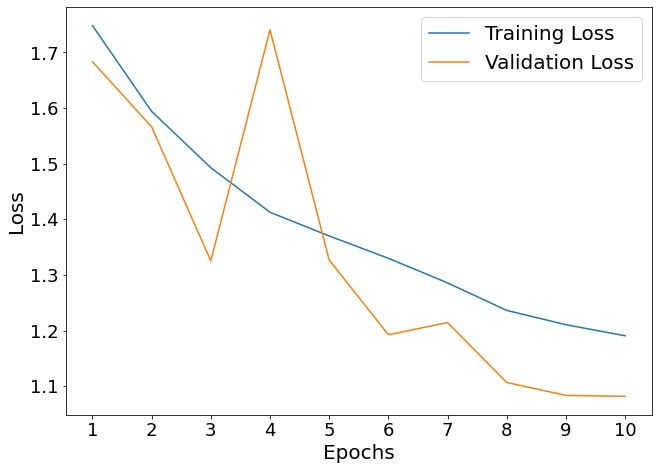

In [14]:
def plot_losses(train_losses, val_losses):
    """
    Function takes training and validation epoch losses and plots them.

    Input: 1) train_losses - list of training epoch losses
           2) val_losses - list of validation epoch losses

    Return: plot the training and validation losses
    """
    fig = plt.gcf()
    fig.set_size_inches(10.5, 7.5)
    plt.plot(list(range(1, len(train_losses) + 1)), train_losses, label='Training Loss')
    plt.plot(list(range(1, len(val_losses) + 1)), val_losses, label='Validation Loss')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.legend(fontsize=20)
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()
    fig.savefig('test2png.png', dpi=100)

plot_losses(train_losses, val_losses)

# Testing the model on the test set


In [15]:
# download the best trained model weights with the validation accuracy 70%
!wget -c https://www.dropbox.com/s/axtvckf6zmc3a3g/opt_model70.pt

# load the model weights on CPU
model_weights = torch.load("/content/opt_model70.pt", map_location={'cuda:0': 'cpu', 'cuda:1' : 'cpu'})

# load the inference model with pretrained weights
model_inference = UpgradedNet(dropout = 0.0, channel_coef=2)
model_inference.load_state_dict(model_weights)
model_inference.to(device)

--2021-05-25 11:37:54--  https://www.dropbox.com/s/axtvckf6zmc3a3g/opt_model70.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/axtvckf6zmc3a3g/opt_model70.pt [following]
--2021-05-25 11:37:54--  https://www.dropbox.com/s/raw/axtvckf6zmc3a3g/opt_model70.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbfd76108155ded5f459b8dd0fa.dl.dropboxusercontent.com/cd/0/inline/BPJoEgM-s037u1ykJBzBJgVDxlqj3GqZltfHjbkC3VE_5X-PiKbQc9CHjODnjQq4KK50TRtANz1M36I_zklPo4JmHys5KebLTNEkjoEBanUlRHjaRB7zV2hKmYiyQl729r1f6U-twNaj52juc7Q0D_I-/file# [following]
--2021-05-25 11:37:54--  https://ucbfd76108155ded5f459b8dd0fa.dl.dropboxusercontent.com/cd/0/inline/BPJoEgM-s037u1ykJBzBJgVDxlqj3GqZltfHjbkC3VE_5X-PiKbQc9CHjODnjQq4KK50TRtANz1M36I_zkl

UpgradedNet(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn5): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn7): Conv2d(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn8): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn9): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (cnn10): Conv2d(256, 7, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps

In [16]:
def test_model(model_inference, testloader):
    """
    Function that tests the model and prints a classification report on the test data.

    Input: 1) model_inference - the trained model
           2) testloader - test dataloader

    Return: displays the classification report of the model over the test set
    """
    ### TESTING ###
    val_running_loss = 0
    val_accuracy = 0
    # initialize lists for the confusion matrix
    y_pred_list = []
    y_gt_list = []

    # set a model to the evaluation mode (freeze the weights)
    model_inference.eval()

    # disable the backpropogation
    with torch.no_grad():
        # iterate over batches
        for images, labels in testloader:
            # put images and labels of a batch on GPUs
            images, labels = images.cuda(), labels.long().cuda()
            # perform modeling for each image batch,
            log_probs = model_inference(images)[-1]
            # calculate the validation loss
            val_running_loss += criterion(log_probs, labels)
            # get the probability distribution over the classes
            probs = torch.exp(log_probs)
            # get the index of the highest probability
            _, predicted = torch.max(probs.data, 1)
            matched = (predicted == labels).squeeze()
            # calculate the accuracy
            val_accuracy += torch.mean(matched.type(torch.FloatTensor))

            # append the lists with predictions and labels to calculate F1 score, precision and recall
            y_pred_list.append(predicted.cpu().numpy())
            y_gt_list.append(labels.cpu().numpy())

    # calculate and report accuracy, F1 score, precision, and recall of the test set
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_gt_list = [a.squeeze().tolist() for a in y_gt_list]
    y_pred_list_new = list(itertools.chain.from_iterable(y_pred_list))
    y_gt_list_new = list(itertools.chain.from_iterable(y_gt_list))

    # calculate the epoch test loss
    val_losses.append(val_running_loss / len(testloader))

    # report the performance of the current epoch
    print(f"Test performance ===>",
          f"Test Loss: {val_losses[-1]:.3f}",
          f"Test Acc: {val_accuracy/len(testloader):.3f}")

    print("Test metrics:")
    print("\n")
    print(classification_report(np.asarray(y_gt_list_new, dtype=np.float32), np.asarray(y_pred_list_new, dtype=np.float32)))
    print("\n")

### Test the model
test_model(model_inference, testloader)

Test performance ===> Test Loss: 1.012 Test Acc: 0.687
Test metrics:


              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60       467
         1.0       0.84      0.57      0.68        56
         2.0       0.55      0.52      0.54       496
         3.0       0.87      0.86      0.87       895
         4.0       0.57      0.59      0.58       653
         5.0       0.80      0.79      0.79       415
         6.0       0.58      0.60      0.59       607

    accuracy                           0.68      3589
   macro avg       0.69      0.65      0.66      3589
weighted avg       0.68      0.68      0.68      3589





# Predict labels

True label: Surprise
Predicted label: Surprise


<Figure size 432x288 with 0 Axes>

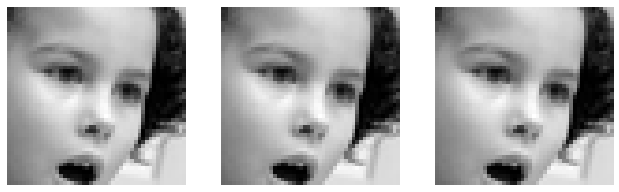

In [17]:
def predict_random_img(model_inference, testloader):
    """
    Function that visualizes a prediction of the model on a random image from a test dataset.
    
    Input: 1) model_inference - the trained model
           2) testloader - test dataloader

    Return: visualization of the given image, true and predicted labels of that image
    """

    # set a model to the evaluation mode (freeze the weights)
    model_inference.eval()

    # get the layers

    # disable the backpropogation
    with torch.no_grad():
        # iterate over batches
        for images, labels in testloader:
            # put images and labels of a batch on GPUs
            images, labels = images.cuda(), labels.long().cuda()
            # perform modeling for each image batch
            inference = model_inference(images)[-1]
            probs = torch.exp(inference)
            # get the index of the highest probability
            _, predicted = torch.max(probs.data, 1)
            break

    # classes definition
    classes = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    idx = np.random.randint(len(images))
    # display original images
    images = images[idx, :, :, :].cpu()
    images = images.data

    print(f"True label: {classes[int(labels[idx].cpu().numpy())]}")
    print(f"Predicted label: {classes[int(predicted[idx].cpu().numpy())]}")

    fig = plt.figure()
    plt.figure(figsize=(30,30))
    for idx, filt in enumerate(images):
        #print(filt[0, :, :])
        #.reshape(filt.shape[0], filt.shape[1])
        plt.subplot(4, 8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')

        #plt.imshow(im.reshape(im.shape[0], im.shape[1])
        
    fig.show()


# run the function
predict_random_img(model_inference, testloader)

# Visualizing filters and weights


In [18]:
def view_filters(model_weights, layer_num=1, size_display=False):
    """
    Function that visualizes the learned filters of the model.

    Input: 1) model_weights - the learned model weights
           2) layer_num - the filter that we want to visualize
           3) size_display - a flag to indicate whether we want to see the feasible number of layer_num
    Return: plots the learned filters
    """

    # display the sizes of convolution weights (tensors)
    tmp_name = f"cnn{layer_num}.weight"
    if size_display:
        print(f"size of layer number {layer_num}:", model_weights[tmp_name].size())

    if model_weights[tmp_name].size()[0] == 32:
        num_cols = 4
        num_rows = 8
    elif model_weights[tmp_name].size()[0] == 64:
        num_cols = 8
        num_rows = 8
    elif model_weights[tmp_name].size()[0] == 128:
        num_cols = 8
        num_rows = 16
    elif model_weights[tmp_name].size()[0] == 256:
        num_cols = 16
        num_rows = 16

    # plot filters
    fig = plt.figure()
    plt.figure(figsize=(10,10))

    for idx, filt in enumerate(model_weights[f"cnn{layer_num}.weight"]):
        # print(filt[0, :, :].shape)
        plt.subplot(num_cols, num_rows, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
        
        
    fig.show()
    plt.tight_layout()

In [19]:
def pass_images(model_inference, testloader, layer_num=0):
    """
    Function that visualizes the feature maps of the layer of the model.

    Input: 1) model_inference - the trained model 
           2) testloader - test data loader
           3) layer_num - the filter that we want to visualize

    Return: visualizes the feature maps of the layer of the model.
    """

    # set a model to the evaluation mode (freeze the weights)
    model_inference.eval()

    # get the layers

    # disable the backpropogation
    with torch.no_grad():
        # iterate over batches
        for images, labels in testloader:
            # put images and labels of a batch on GPUs
            images, labels = images.cuda(), labels.long().cuda()
            # perform modeling for each image batch
            inference = model_inference(images)
            break
    
    # display original images
    images = images[15, :, :, :].cpu()
    images = images.data
    print(labels[15])
    print(images.size())

    fig = plt.figure()
    plt.figure(figsize=(30,30))
    for idx, filt in enumerate(images):
        #print(filt[0, :, :])
        #.reshape(filt.shape[0], filt.shape[1])
        plt.subplot(4, 8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')

        #plt.imshow(im.reshape(im.shape[0], im.shape[1])
        
    fig.show()
    
    # display the passing through the layer
    layer = inference[layer_num][15, :16, :, :].cpu()
    layer = layer.data

    fig = plt.figure()
    plt.figure(figsize=(20,20))
    for idx, filt in enumerate(layer):
        #print(filt[0, :, :])
        #.reshape(filt.shape[0], filt.shape[1])
        plt.subplot(8, 8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')

        #plt.imshow(im.reshape(im.shape[0], im.shape[1])
    plt.tight_layout()
    fig.show()

Visualize the learned filters

<Figure size 432x288 with 0 Axes>

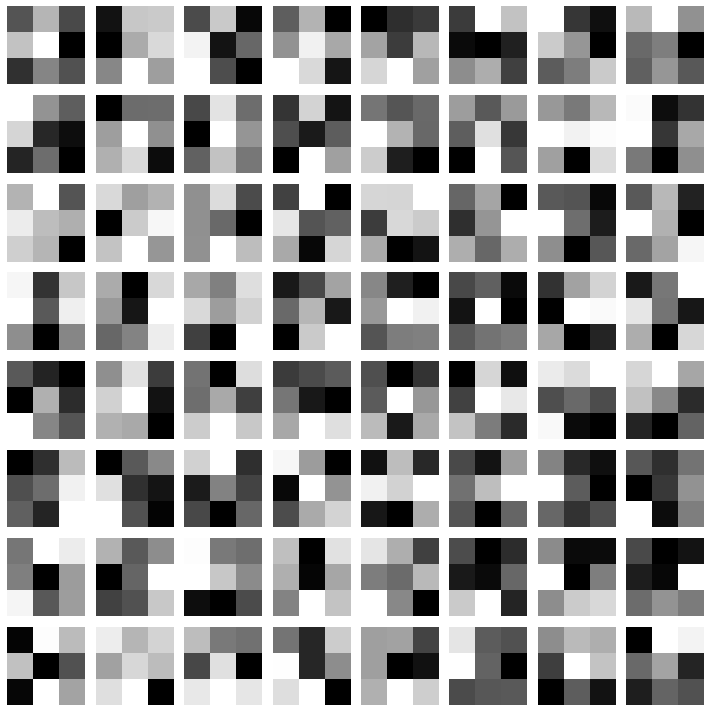

In [20]:
# visualize the learned filters
view_filters(model_weights, layer_num=1, size_display=False)

Visualize the feature maps of the different convolutional layers

tensor(2, device='cuda:0')
torch.Size([3, 48, 48])


<Figure size 432x288 with 0 Axes>

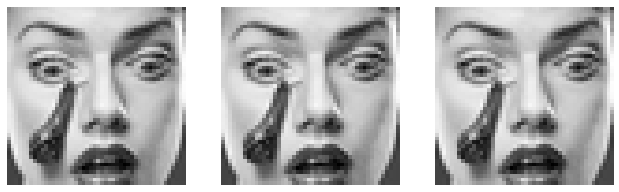

<Figure size 432x288 with 0 Axes>

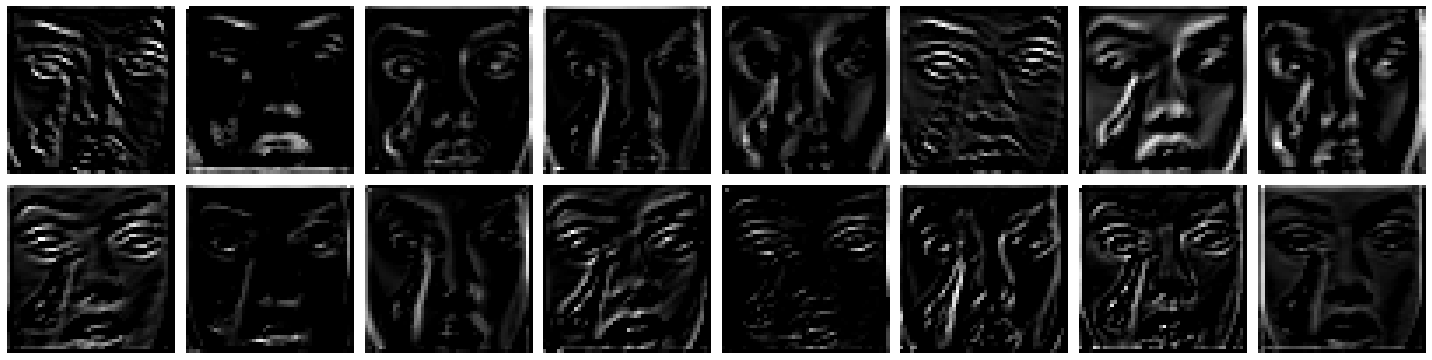

In [21]:
pass_images(model_inference, testloader, layer_num=3)

tensor(2, device='cuda:0')
torch.Size([3, 48, 48])


<Figure size 432x288 with 0 Axes>

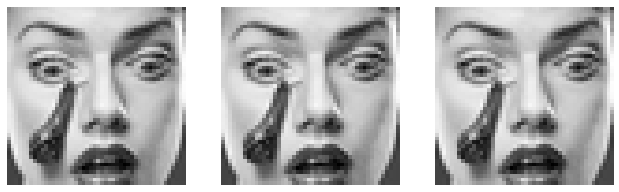

<Figure size 432x288 with 0 Axes>

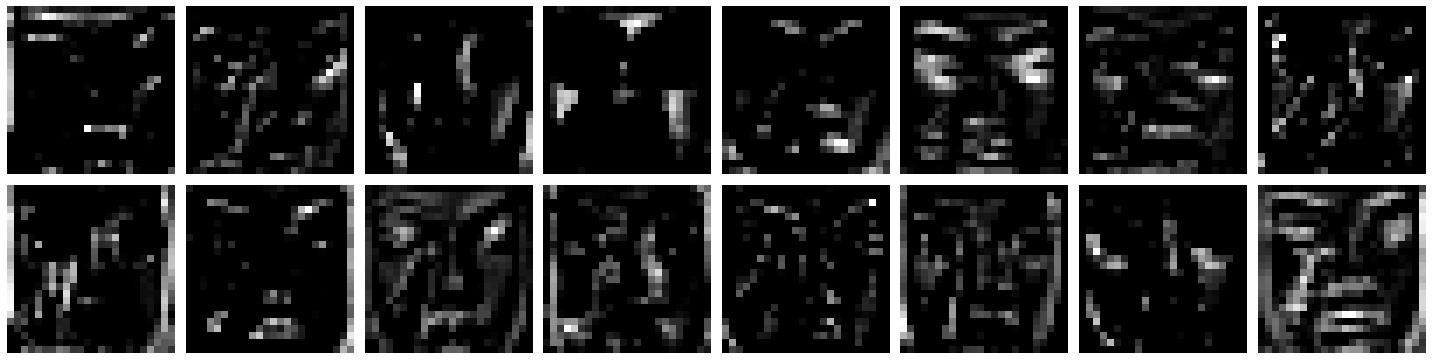

In [22]:
pass_images(model_inference, testloader, layer_num=5)

tensor(2, device='cuda:0')
torch.Size([3, 48, 48])


<Figure size 432x288 with 0 Axes>

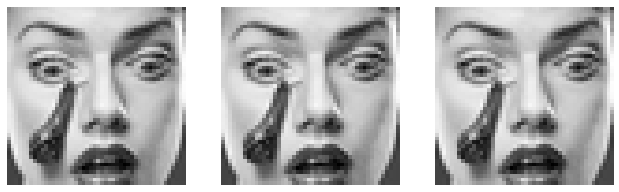

<Figure size 432x288 with 0 Axes>

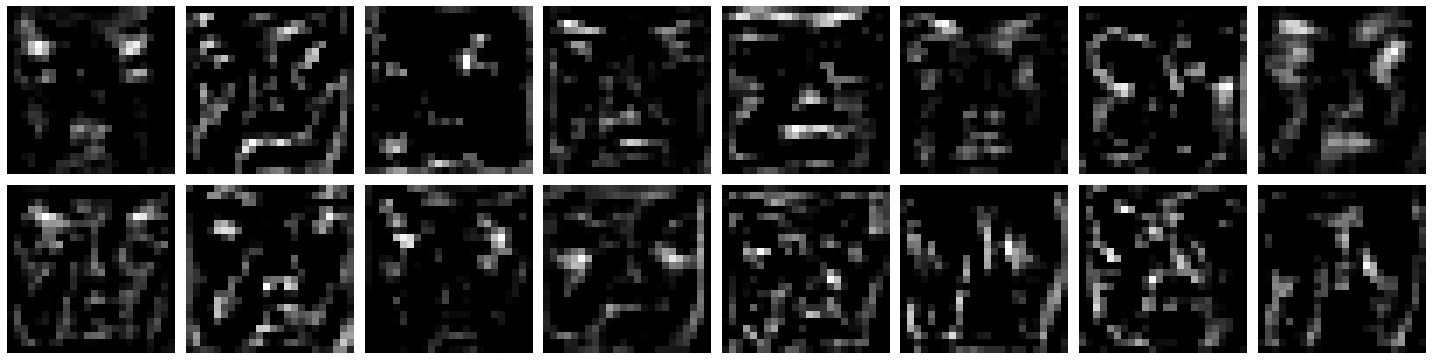

In [23]:
pass_images(model_inference, testloader, layer_num=7)

tensor(2, device='cuda:0')
torch.Size([3, 48, 48])


<Figure size 432x288 with 0 Axes>

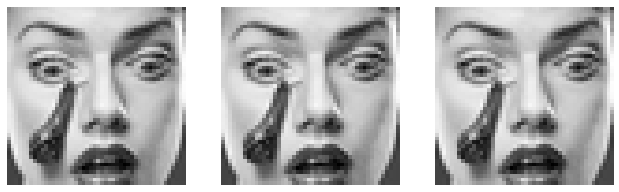

<Figure size 432x288 with 0 Axes>

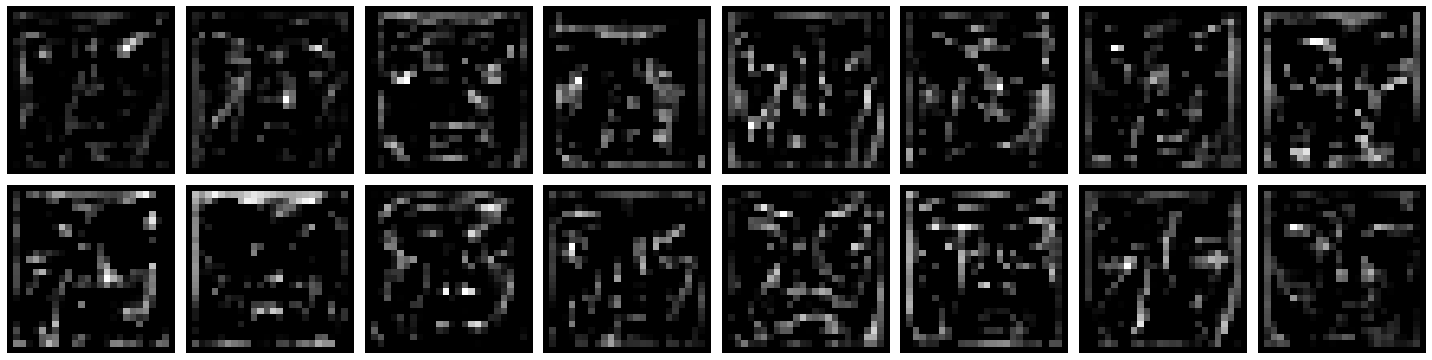

In [24]:
pass_images(model_inference, testloader, layer_num=9)

tensor(2, device='cuda:0')
torch.Size([3, 48, 48])


<Figure size 432x288 with 0 Axes>

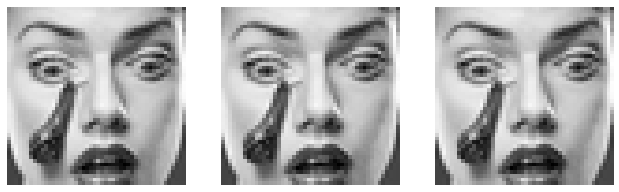

<Figure size 432x288 with 0 Axes>

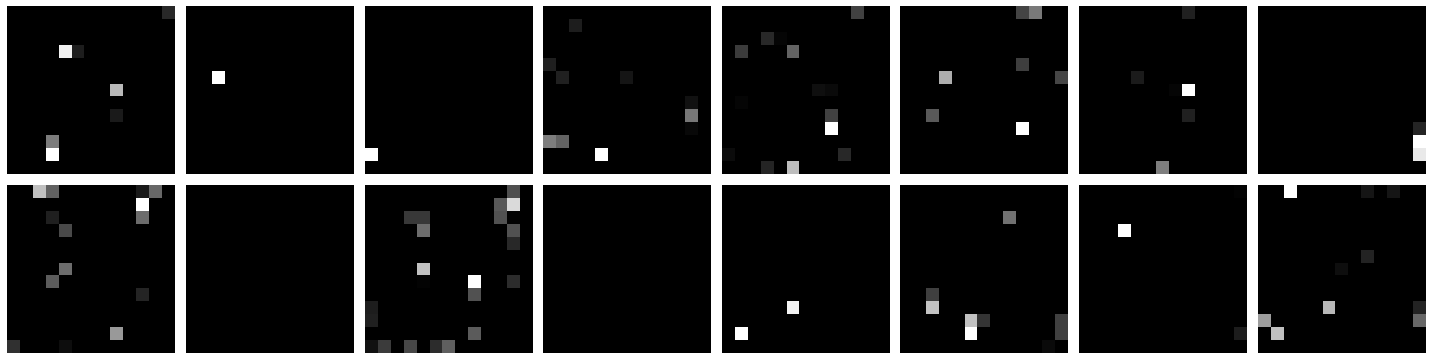

In [25]:
pass_images(model_inference, testloader, layer_num=-8)